## Split CIFAR-10 into training, validation, and testing sets

In [1]:
##########################
### SETTINGS
##########################

NUM_CLASSES = 10

# Hyperparameters
random_seed = 1
lr = 0.0001
num_epochs = 60
batch_size = 32

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

train_transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1421: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


## Visualize image for each class

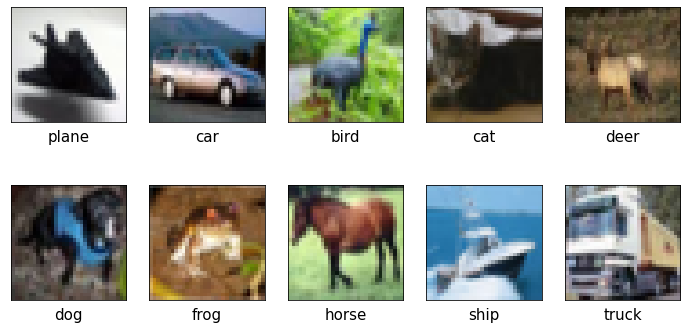

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define CNN architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits



net = AlexNet(NUM_CLASSES)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Device: cuda:0
Number of trainable parameters: 57044810


In [5]:
''' my AlexNet 
# AlexNet model
class AlexNet(nn.Module):
    
    def __init__(self, num_classes: int = 17):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            # first layer
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            # activation function
            nn.ReLU(inplace=True),
            # pooling
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            # fully connected layer
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, NUM_CLASSES) # 2 classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)

'''
# User pytorch
# net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

' my AlexNet \n# AlexNet model\nclass AlexNet(nn.Module):\n    \n    def __init__(self, num_classes: int = 17):\n        super(AlexNet, self).__init__()\n\n        self.convolutional = nn.Sequential(\n            # first layer\n            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),\n            # activation function\n            nn.ReLU(inplace=True),\n            # pooling\n            nn.MaxPool2d(kernel_size=3, stride=2),\n\n            nn.Conv2d(64, 192, kernel_size=5, padding=2),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=3, stride=2),\n\n            nn.Conv2d(192, 384, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n\n            nn.Conv2d(384, 256, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n\n            nn.Conv2d(256, 256, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=3, stride=2),\n        )\n\n        # average pooling layer\n        self.avgp

## Training

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(num_epochs):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))




[epoch 1] loss: 0.05119 accuracy: 0.3896 val loss: 0.04040 val accuracy: 0.5324
[epoch 2] loss: 0.03758 accuracy: 0.5665 val loss: 0.03251 val accuracy: 0.6309
[epoch 3] loss: 0.03137 accuracy: 0.6452 val loss: 0.03113 val accuracy: 0.6545
[epoch 4] loss: 0.02677 accuracy: 0.6990 val loss: 0.02475 val accuracy: 0.7239
[epoch 5] loss: 0.02393 accuracy: 0.7321 val loss: 0.02192 val accuracy: 0.7571
[epoch 6] loss: 0.02152 accuracy: 0.7595 val loss: 0.02137 val accuracy: 0.7680
[epoch 7] loss: 0.01978 accuracy: 0.7804 val loss: 0.01899 val accuracy: 0.7922
[epoch 8] loss: 0.01841 accuracy: 0.7949 val loss: 0.01786 val accuracy: 0.8029
[epoch 9] loss: 0.01695 accuracy: 0.8110 val loss: 0.01884 val accuracy: 0.7952
[epoch 10] loss: 0.01590 accuracy: 0.8233 val loss: 0.01723 val accuracy: 0.8106
[epoch 11] loss: 0.01480 accuracy: 0.8352 val loss: 0.01656 val accuracy: 0.8205
[epoch 12] loss: 0.01383 accuracy: 0.8447 val loss: 0.01563 val accuracy: 0.8284
[epoch 13] loss: 0.01305 accuracy: 0.

## Plotting training statistics

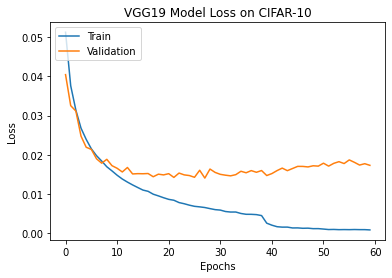

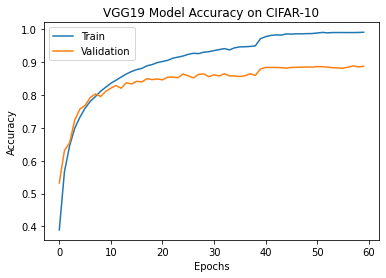

In [7]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('VGG19 Model Loss on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('VGG19 Model Accuracy on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Save the trained model

In [8]:
from google.colab import files

torch.save(net.state_dict(), 'checkpoint.pth')
# download checkpoint file
files.download('checkpoint.pth')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
net.load_state_dict(torch.load('checkpoint.pth'))

## Testing

In [9]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 88.96 %


## Visualize wrongly classified image for each class

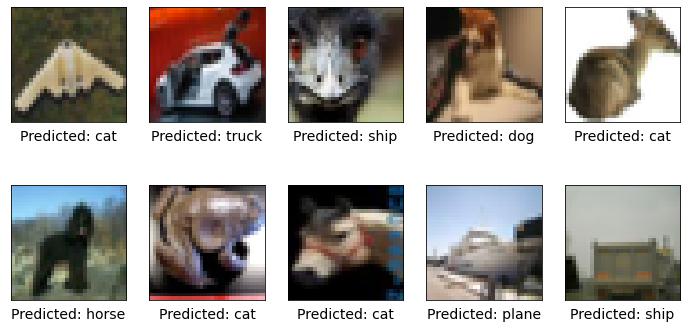

In [10]:
import numpy as np

# visualize wrongly classified image for each class
pred_vec = pred_vec.cpu().numpy()
ground_truths = np.asarray(test_set.targets)
incorrect_mask = pred_vec != ground_truths
incorrect_images = [test_set.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results = [pred_vec[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results[i]], fontsize=14)
    axis.imshow(incorrect_images[i])
    i += 1